In [1]:
# python
import os
from itertools import combinations, product

# stats
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.api import OLS

# plot
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib_venn import venn3


# analysis code
from lib.functions_second_analysis import *
from lib.functions_scripting import *


beauty_ratings = load_ratings(PATH_RATINGS)
modelorder = pd.read_pickle(os.path.join(PATH_RESULTS, "model order.pkl"))
BLOCKING_GROUPS = np.insert(np.repeat(range(1, 16 + 1), 3), 0, 0)

In [10]:
modelorder[::-1]

model
vanishing_point     22
keypoints2d         21
point_matching      20
segment_unsup25d    19
jigsaw              18
keypoints3d         17
fixated_pose        16
segment_unsup2d     15
edge_occlusion      14
reshading           13
autoencoding        12
egomotion           11
class_scene         10
denoising            9
edge_texture         8
inpainting           7
segment_semantic     6
normal               5
class_object         4
room_layout          3
nonfixated_pose      2
depth_euclidean      1
curvature            0
dtype: int64

In [2]:
# all, exceptscale32
_models = MODEL_NAMES
_studies = STUDY_NAMES
_datasets = DATASET_NAMES
_scales = SCALE_NAMES[:3]

In [2]:
# best 13 models, scale 2 - 16
topmodels = modelorder[10:].index.to_list()
_studies = STUDY_NAMES
_datasets = DATASET_NAMES
_scales = SCALE_NAMES[:3]

In [3]:
# unblocked data
_blocking = "unblocked"
_layers = slice(None)

dfi = load_integration(PATH_INTEGRATION)
dfibc = load_ibcorr(PATH_IBCORR)

dfi = dfi.sort_index().loc[(_models, _datasets, _scales, slice(None), _layers)]
dfibc = dfibc.sort_index().loc[(_models, _studies, _scales, _layers)]

In [ ]:
# averaged data
_blocking = "average"
_layers = slice(None)

dfi = load_integration(PATH_INTEGRATION_AVERAGE)
dfibc = load_ibcorr(PATH_IBCORR_AVERAGE)

dfi = dfi.sort_index().loc[(_models, _datasets, _scales, slice(None), _layers)]
dfibc = dfibc.sort_index().loc[(_models, _studies, _scales, _layers)]

In [3]:
# maxpooled data
_blocking = "maxpool"
_layers = slice(None)

dfi = load_integration(PATH_INTEGRATION_MAXPOOL)
dfibc = load_ibcorr(PATH_IBCORR_MAXPOOL)

dfi = dfi.sort_index().loc[(_models, _datasets, _scales, slice(None), _layers)]
dfibc = dfibc.sort_index().loc[(_models, _studies, _scales, _layers)]

Integration profile between layers

RDM of RDM's that correlate integration ratings of each different layers inside each network.


TODO: Is this essentially the same thing as absoloute correlation differences alone ?
copy code for each models layerXlayer RDM
correlate correlations using daniels code

# 1st order RSA: layerXlayer integration

pearson

In [4]:
df_rsa1 = (
    dfi.unstack("layer").groupby(["dataset", "scale", "model"]).apply(calculate_rdm)
)

df_rsa1 = df_rsa1.droplevel(None, axis=0).droplevel(None, axis=1)

In [19]:
df_rsa1.to_hdf(
    os.path.join(
        PATH_RESULTS,
        "layer profile",
        "rsa1 " + _blocking + ".h5",
    ),
    key="df_rsa1",
)

In [34]:
df_rsa1 = pd.read_hdf(
    os.path.join(
        PATH_RESULTS,
        "layer profile",
        "rsa1 " + _blocking + ".h5",
    ),
    key="df_rsa1",
)

In [6]:
df_rsa1.to_hdf(
    os.path.join(
        PATH_RESULTS,
        "layer profile",
        "rsa1 allmodels " + _blocking + ".h5",
    ),
    key="df_rsa1",
)

In [8]:
df_rsa1 = pd.read_hdf(
    os.path.join(
        PATH_RESULTS,
        "layer profile",
        "rsa1 allmodels " + _blocking + ".h5",
    ),
    key="df_rsa1",
)

spearman

In [ ]:
df_rsa1_spearman = (
    dfi.unstack("layer").groupby(["dataset", "scale", "model"]).apply(calculate_rdm, ctype="spearman")
)

df_rsa1_spearman = df_rsa1_spearman.droplevel(None, axis=0).droplevel(None, axis=1)

In [49]:
df_rsa1_spearman.to_hdf(
    os.path.join(
        PATH_RESULTS,
        "layer profile",
        "rsa1 " + _blocking + " spearman.h5",
    ),
    key="df_rsa1_spearman",
)

In [ ]:
df_rsa1_spearman = pd.read_hdf(
    os.path.join(
        PATH_RESULTS,
        "layer profile",
        "rsa1 " + _blocking + " spearman.h5",
    ),
    key="df_rsa1_spearman",
)

## plot across datasets

In [340]:
modelplotorder = [
    "class_scene",
    "egomotion",
    "segment_unsup2d",
    "segment_unsup25d",
    "point_matching",
    "keypoints3d",
    "autoencoding",
    "keypoints2d",
    "jigsaw",
    "reshading",
    "edge_occlusion",
    "fixated_pose",
    "vanishing_point",
]

### plotfunction

In [60]:
def plot_layerprofile_datasets(data, modelplotorder):
    fig, axes = plt.subplots(7, 6, figsize=(15.75, 21), sharex=True, sharey=True)
    modelplotorder = np.array(modelplotorder)
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "custom_diverging", ["orange", "white", "blue"]
    )

    f1 = 20
    f2 = 16

    ticks = np.where(np.diff(BLOCKING_GROUPS))[0][1::3]

    for (mo, da), ax in zip(product(modelplotorder, DATASET_NAMES), axes.flat):
        im = ax.imshow(
            data.loc[(da, mo)],
            vmin=-data.max().max(),
            vmax=data.max().max(),
            cmap=cmap,
        )
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)

        # first row: dataset titles and model title in the middle
        if mo in modelplotorder[[0, 1]] and da == DATASET_NAMES[1]:
            ax.set_title(da + "\n" + mo, fontsize=f1)
        elif mo in modelplotorder[[0, 1]]:
            ax.set_title(da + "\n", fontsize=f1)
        elif da == DATASET_NAMES[1]:
            ax.set_title(mo, fontsize=f1)

        # first column: y-axis
        if da == DATASET_NAMES[0] and mo in modelplotorder[::2]:
            ax.set_ylabel("layer", fontsize=f2)


    axes.flat[-3].axis('off')
    axes.flat[-2].axis('off')
    axes.flat[-1].axis('off')
    # cbar
    fig.colorbar(
        im,
        ax=axes.flat[-2],
        orientation="horizontal",
        fraction=.5,
        #pad=0.03,
        shrink=3,
    ).set_label('Pearson correlation', fontsize=f2)

    # vertical seperation line
    mid = 0.513
    fig.add_artist(
        plt.Line2D(
            [mid, mid],
            [0.12, 0.89],
            color="magenta",
            lw=3,
            transform=fig.transFigure,
        )
    )
    plt.subplots_adjust(wspace=0.1)

### scale4 spearman

In [270]:
data = (
    df_rsa1_spearman.loc[(slice(None), "scale4", topmodels, slice(None))]
    .droplevel("scale")
    .copy()
)

#### all correlations

<ipython-input-243-ea164d2001fe>:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  data.loc[(da, mo)],


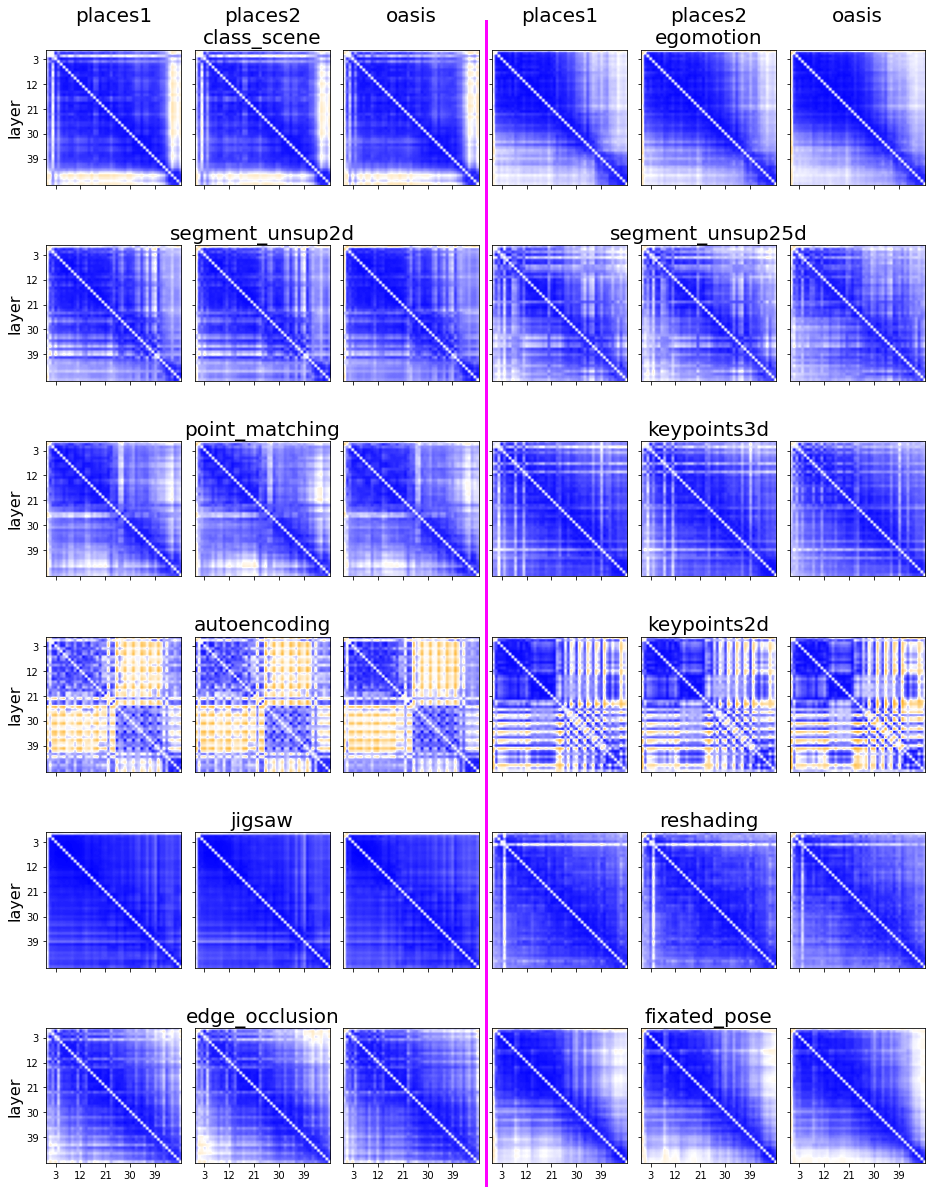

In [271]:
plot_layerprofile_datasets(data, modelplotorder)

#### threshold at .75

<ipython-input-243-ea164d2001fe>:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  data.loc[(da, mo)],


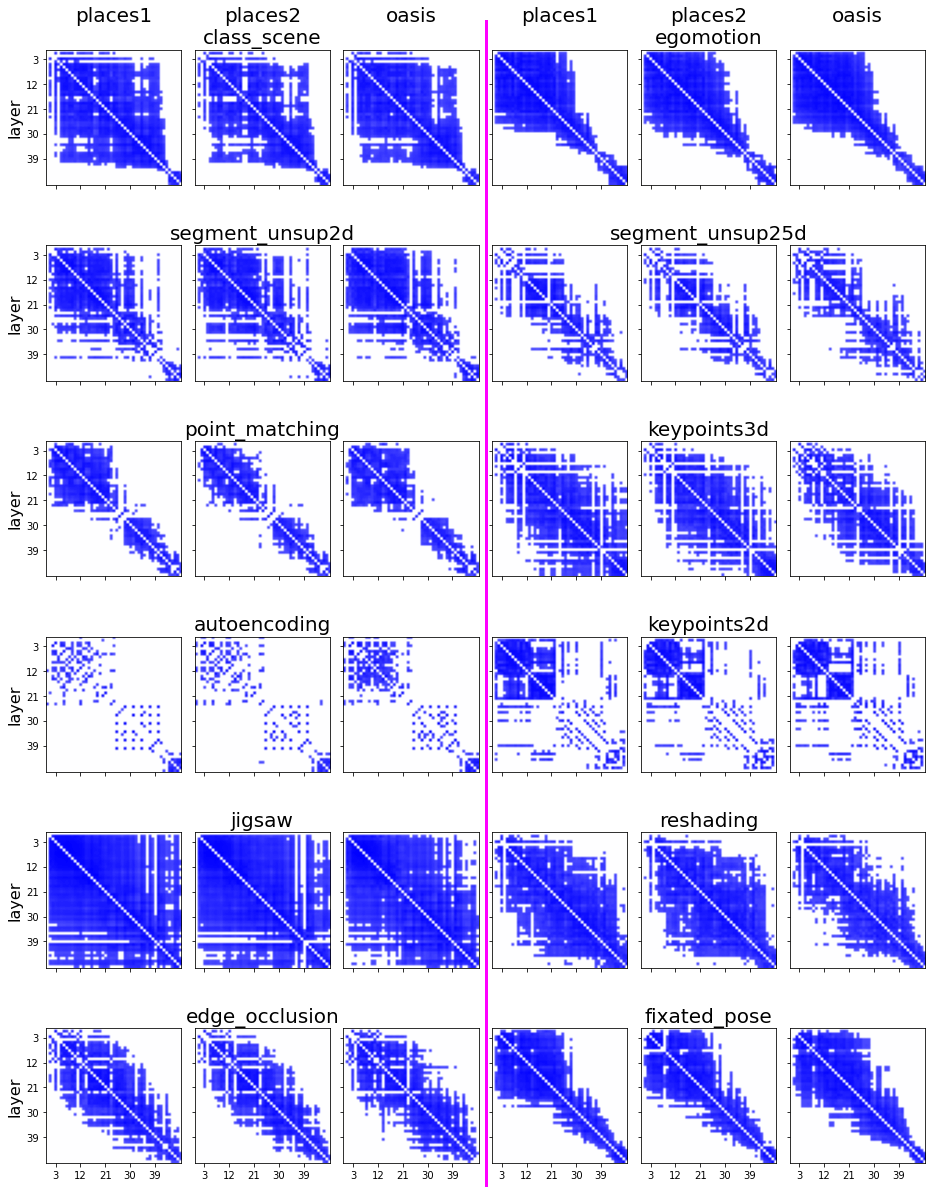

In [272]:
data[data<.7] = 0
plot_layerprofile_datasets(data, modelplotorder)

### scale4 pearson

In [346]:
data = (
    df_rsa1.loc[(slice(None), "scale4", topmodels, slice(None))]
    .droplevel("scale")
    .copy()
)

In [ ]:
# no threshold
plot_layerprofile_datasets(data, modelplotorder)

In [ ]:
# threshold
data[data<.7] = 0  
plot_layerprofile_datasets(data, modelplotorder)

<ipython-input-60-e04e6b1ad214>:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  data.loc[(da, mo)],


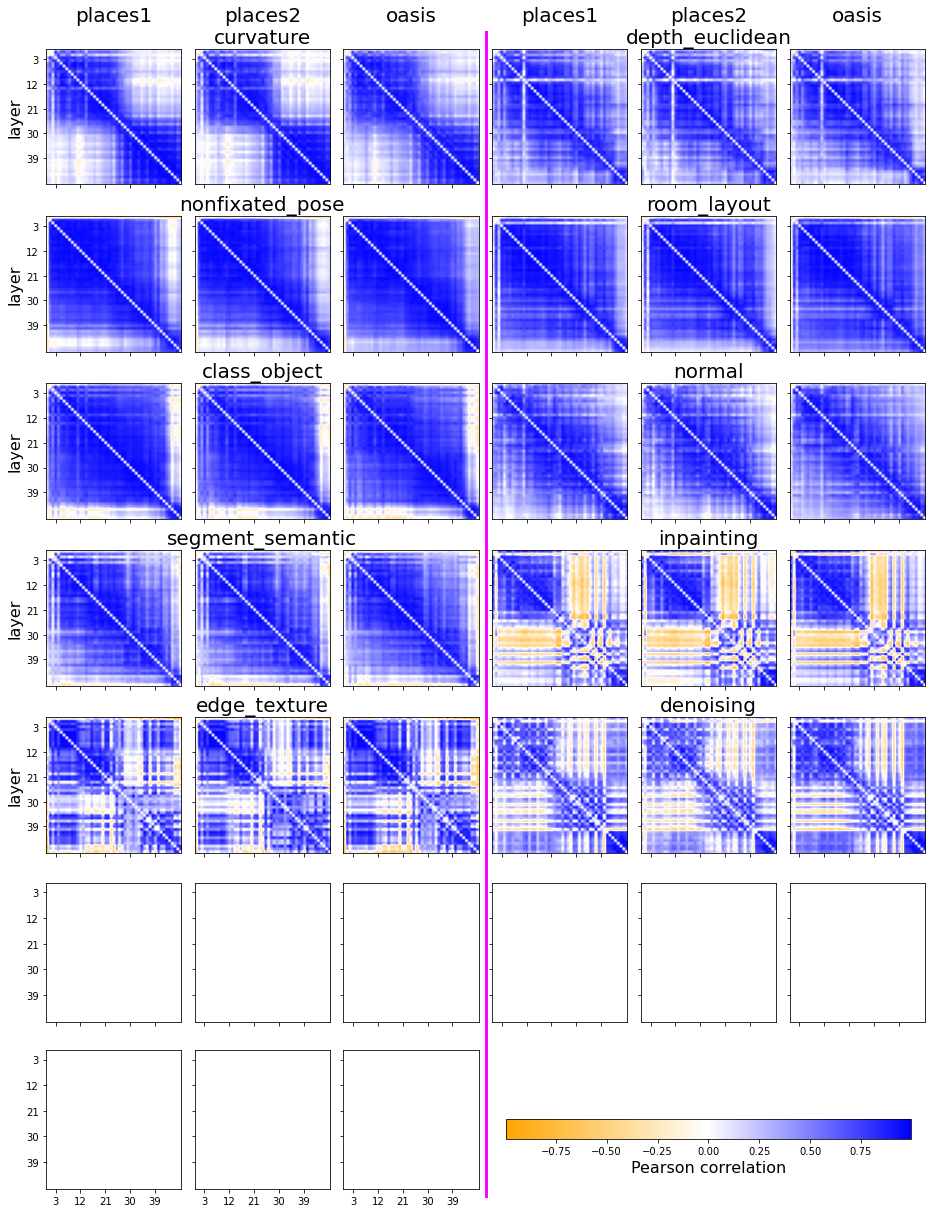

In [61]:
# non predictive models
badmodels = modelorder[:10]
modelplotorder = badmodels.index.to_list()
data = (
    df_rsa1.loc[(slice(None), "scale4", modelplotorder, slice(None))]
    .droplevel("scale")
    .copy()
)

plot_layerprofile_datasets(data, modelplotorder)

## plot across scales

In [ ]:
modelplotorder = [
    "class_scene",
    "egomotion",
    "segment_unsup2d",
    "segment_unsup25d",
    "point_matching",
    "keypoints3d",
    "autoencoding",
    "keypoints2d",
    "jigsaw",
    "reshading",
    "edge_occlusion",
    "fixated_pose",
]

### plotfunction

In [303]:
def plot_layerprofile_scales(data, modelplotorder):
    fig, axes = plt.subplots(6, 6, figsize=(15.75, 21), sharex=True, sharey=True)
    modelplotorder = np.array(modelplotorder)
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "custom_diverging", ["orange", "white", "blue"]
    )

    f1 = 20
    f2 = 16

    ticks = np.where(np.diff(BLOCKING_GROUPS))[0][1::3]

    for (mo, sc), ax in zip(product(modelplotorder, SCALE_NAMES[:3]), axes.flat):

        im = ax.imshow(
            data.loc[(sc, mo)],
            vmin=-data.max().max(),
            vmax=data.max().max(),
            cmap=cmap,
        )
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)

        # first row: dataset titles and model title in the middle
        if mo in modelplotorder[[0, 1]] and sc == SCALE_NAMES[1]:
            ax.set_title(sc + "\n" + mo, fontsize=f1)
        elif mo in modelplotorder[[0, 1]]:
            ax.set_title(sc + "\n", fontsize=f1)
        elif sc == SCALE_NAMES[1]:
            ax.set_title(mo, fontsize=f1)

        # first column: y-axis
        if sc == DATASET_NAMES[0] and mo in modelplotorder[::2]:
            ax.set_ylabel("layer", fontsize=f2)

    # vertical seperation line
    mid = 0.513
    fig.add_artist(
        plt.Line2D(
            [mid, mid],
            [0.12, 0.89],
            color="magenta",
            lw=3,
            transform=fig.transFigure,
        )
    )
    plt.subplots_adjust(wspace=0.1)

### places1 pearson

In [309]:
data = (
    df_rsa1.loc[("places1", SCALE_NAMES[:3], topmodels, slice(None))]
    .droplevel("dataset")
    .copy()
)

#### all correlations

<ipython-input-303-0d52e2f36fa6>:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  data.loc[(sc, mo)],


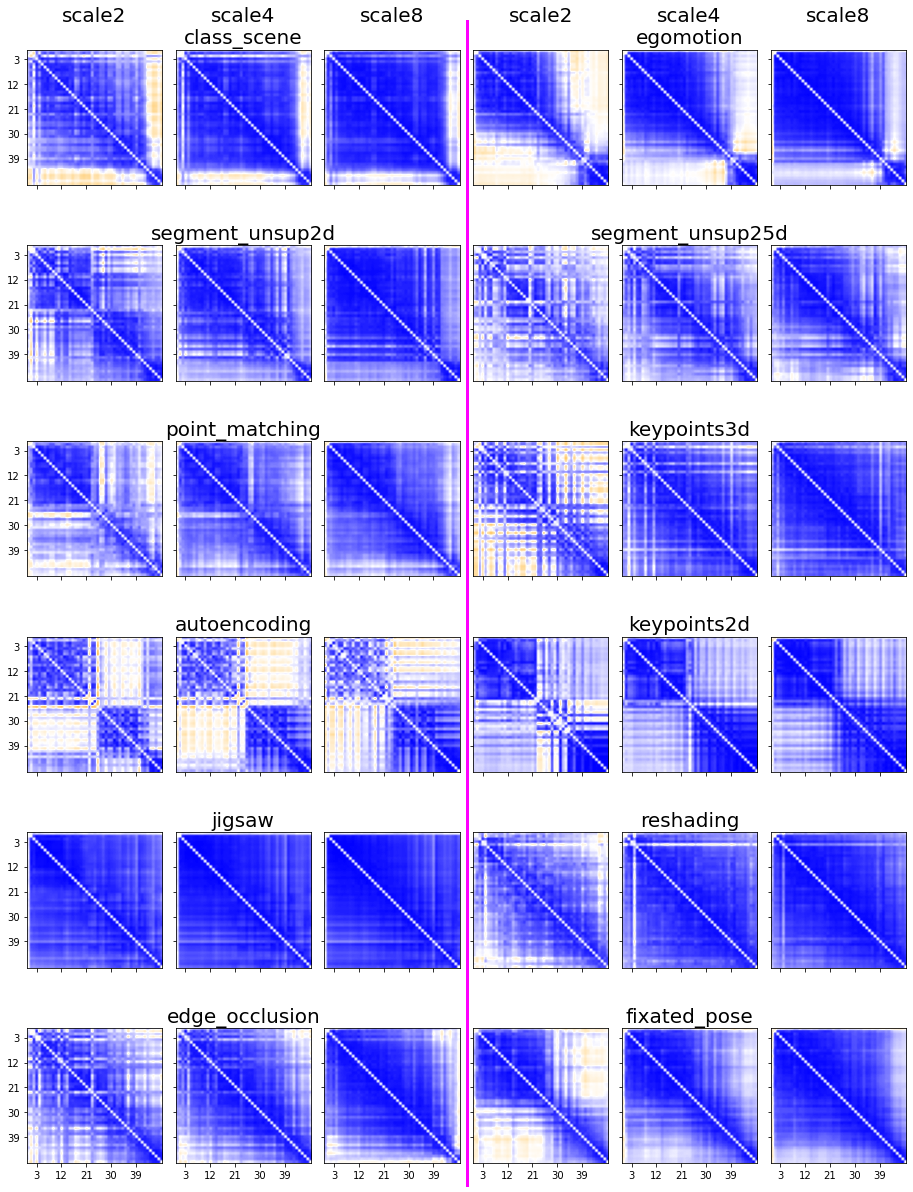

In [310]:
plot_layerprofile_scales(data, modelplotorder)

#### thresholded

<ipython-input-303-0d52e2f36fa6>:16: PerformanceWarning: indexing past lexsort depth may impact performance.
  data.loc[(sc, mo)],


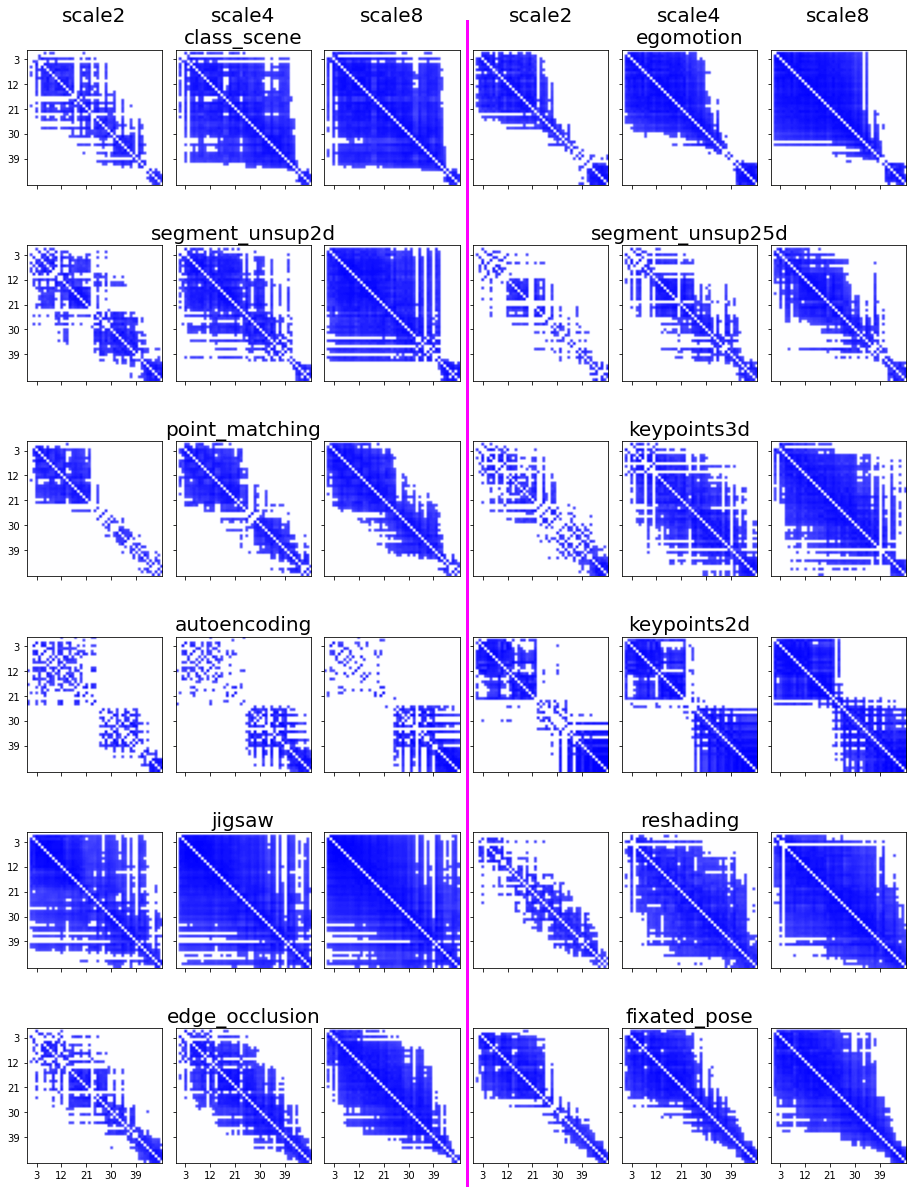

In [311]:
data[data<.7] = 0 
plot_layerprofile_scales(data, modelplotorder)

## appendix

### across datasets, all scales

In [ ]:
# 

### across scales, all datasets

# 2nd order RSA: correlate 1st order RDMs (scale, dataset, net)

In [ ]:
params = list(product(_datasets, _scales, topmodels))

idx = pd.MultiIndex.from_tuples(params, names=["dataset", "scale", "model"])
df_rsa2 = pd.DataFrame(np.nan, index=idx, columns=idx)

for par1, par2 in combinations(params, 2):
    c = correlate_rdms(df_rsa1.loc[par1], df_rsa1.loc[par2])[0]
    df_rsa2.loc[par1, par2], df_rsa2.loc[par2, par1] = c, c

df_rsa2.fillna(0, inplace=True)

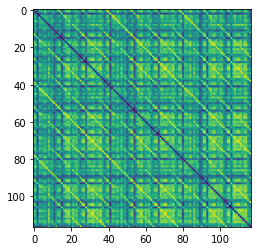

In [424]:
plt.imshow(df_rsa2)

In [475]:
df_rsa2.to_hdf(
    os.path.join(PATH_RESULTS, "layer profile", "rsa2 unblocked.h5"), key="df_rsa2"
)

In [5]:
df_rsa2 = pd.read_hdf(
    os.path.join(PATH_RESULTS, "layer profile", "rsa2 unblocked.h5"), key="df_rsa2"
)

## compare influence of scale, dataset, net on 2nd order RDM

### model RDM

<ipython-input-6-b5000bde6f82>:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  modelRDM_datasets.loc[(da1, sc1, mo1), (da1, sc2, mo2)] = 1
<ipython-input-6-b5000bde6f82>:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  modelRDM_datasets.loc[(da2, sc2, mo2), (da2, sc1, mo1)] = 1


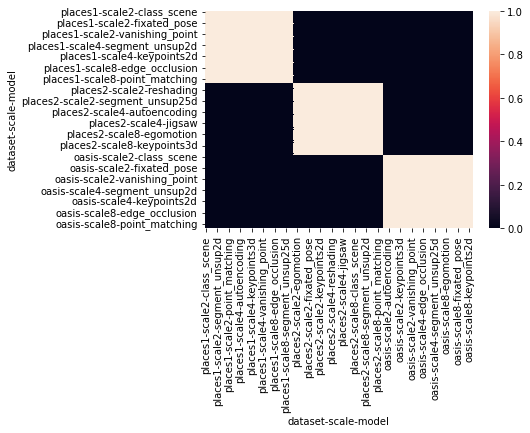

In [6]:
modelRDM_datasets = pd.DataFrame(
    np.zeros(df_rsa2.shape), index=df_rsa2.index, columns=df_rsa2.columns
)
for (da1, sc1, mo1), (da2, sc2, mo2) in combinations(params, 2):
    modelRDM_datasets.loc[(da1, sc1, mo1), (da1, sc2, mo2)] = 1
    modelRDM_datasets.loc[(da2, sc2, mo2), (da2, sc1, mo1)] = 1
    
sns.heatmap(modelRDM_datasets)

<ipython-input-7-9f5e2a752686>:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  modelRDM_scales.loc[(da1, sc1, mo1), (da2, sc1, mo2)] = 1
<ipython-input-7-9f5e2a752686>:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  modelRDM_scales.loc[(da2, sc2, mo2), (da1, sc2, mo1)] = 1


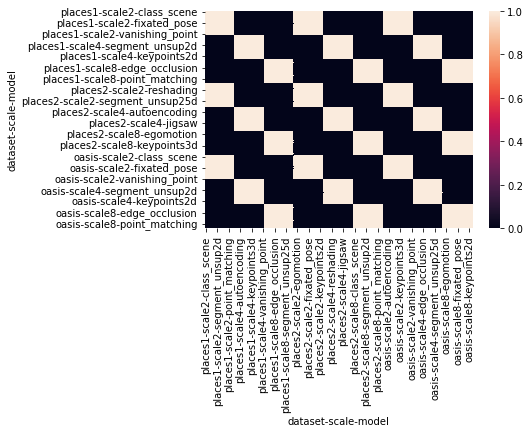

In [7]:
modelRDM_scales = pd.DataFrame(
    np.zeros(df_rsa2.shape), index=df_rsa2.index, columns=df_rsa2.columns
)
for (da1, sc1, mo1), (da2, sc2, mo2) in combinations(params, 2):
    modelRDM_scales.loc[(da1, sc1, mo1), (da2, sc1, mo2)] = 1
    modelRDM_scales.loc[(da2, sc2, mo2), (da1, sc2, mo1)] = 1

sns.heatmap(modelRDM_scales)

<ipython-input-8-a05a97afd82a>:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  modelRDM_networks.loc[(da1, sc1, mo1), (da2, sc2, mo1)] = 1
<ipython-input-8-a05a97afd82a>:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  modelRDM_networks.loc[(da2, sc2, mo2), (da1, sc1, mo2)] = 1


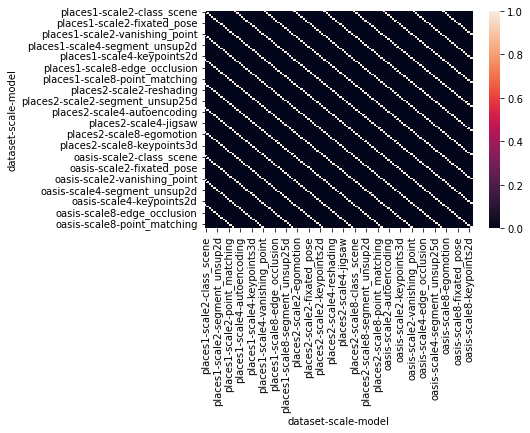

In [8]:
modelRDM_networks = pd.DataFrame(
    np.zeros(df_rsa2.shape), index=df_rsa2.index, columns=df_rsa2.columns
)
for (da1, sc1, mo1), (da2, sc2, mo2) in combinations(params, 2):
    modelRDM_networks.loc[(da1, sc1, mo1), (da2, sc2, mo1)] = 1
    modelRDM_networks.loc[(da2, sc2, mo2), (da1, sc1, mo2)] = 1
    
sns.heatmap(modelRDM_networks)

### variance partitioning

In [13]:
correlate_rdms(df_rsa2, modelRDM_datasets)

(-0.014556084509152254, 0.23055445361755336)

In [10]:
correlate_rdms(df_rsa2, modelRDM_scales)

(0.0592345080739635, 1.0450476251959448e-06)

In [11]:
correlate_rdms(df_rsa2, modelRDM_networks)

(0.40188247129828303, 7.716614870411126e-262)

In [14]:
predictors_r2([modelRDM_datasets, modelRDM_scales, modelRDM_networks], df_rsa2)


0.1675248961481418

In [15]:
# unique variances
all = predictors_r2([modelRDM_datasets, modelRDM_scales, modelRDM_networks], df_rsa2)
r2p1 = all - predictors_r2([modelRDM_scales, modelRDM_networks], df_rsa2)
r2p2 = all - predictors_r2([modelRDM_datasets, modelRDM_networks], df_rsa2)
r2p3 = all - predictors_r2([modelRDM_datasets, modelRDM_scales], df_rsa2)

r2p1, r2p2, r2p3

(2.547770696748053e-05, 0.006002921313318921, 0.16383340683391823)

In [16]:
# shared variances
r2p1p2p3 = (
    predictors_r2([modelRDM_datasets], df_rsa2)
    + predictors_r2([modelRDM_scales], df_rsa2)
    + predictors_r2([modelRDM_networks], df_rsa2)
    - 2 * predictors_r2([modelRDM_datasets, modelRDM_scales, modelRDM_networks], df_rsa2)
    + r2p1
    + r2p2
    + r2p3
)
r2p1p2 = (
    predictors_r2([modelRDM_datasets], df_rsa2)
    + predictors_r2([modelRDM_scales], df_rsa2)
    - predictors_r2([modelRDM_datasets, modelRDM_scales], df_rsa2)
    - r2p1p2p3
)
r2p2p3 = (
    predictors_r2([modelRDM_scales], df_rsa2)
    + predictors_r2([modelRDM_networks], df_rsa2)
    - predictors_r2([modelRDM_scales, modelRDM_networks], df_rsa2)
    - r2p1p2p3
)
r2p1p3 = (
    predictors_r2([modelRDM_datasets], df_rsa2)
    + predictors_r2([modelRDM_networks], df_rsa2)
    - predictors_r2([modelRDM_datasets, modelRDM_networks], df_rsa2)
    - r2p1p2p3
)
r2p1p2p3, r2p1p2, r2p2p3, r2p1p3

(4.2140837733684045e-05,
 -1.3023608955942123e-05,
 -0.0025233115953327,
 0.00015728466049214074)

In [17]:
r2_tuple = tuple(round(r2, 2) for r2 in (r2p1, r2p2, r2p1p2, r2p3, r2p1p3, r2p2p3, r2p1p2p3))
r2_tuple

(0.0, 0.01, -0.0, 0.16, 0.0, -0.0, 0.0)

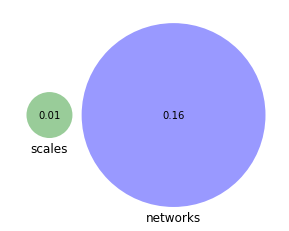

In [22]:
venn3(subsets=r2_tuple, set_labels = ('', 'scales', 'networks'))
plt.gca().set_facecolor('white')

# predictorRDM from best predicting layer

ordering of images by integration in best predicting layer

"what is integrated", alternatively average of correlation between in each layer, howevery layers may not correspond to each other, therefore best predicting layer is more general <br> <br>

Interpretation: The differences in absolout values correspond to how similar the "integration mechanism" in both networks are.<br> If we assume that beauty perception depends on a specific stage of processing and not the whole processing stream, then the best predicting layer of a network can be interpreted as the point, where the network best mimics the aspects of the processing that determine beauty. <br> 

If the a similar The value in Is there a single or are there different ways of predicting beauty ?`

In [ ]:
bestlayers = (
    dfibc.groupby(["study", "scale", "model"])
    .idxmax()
    .ibcorr.transform(lambda idx: idx[-1])
    .to_frame()
    .reset_index()
    .values.tolist()
)

In [ ]:
dfi2 = dfi.reorder_levels(("dataset", "scale", "model", "layer", "img"))

dfi2.index = dfi2.index.set_names(level="dataset", names="study").set_levels(
    dfi2.index.levels[0].map(
        {
            "places1": "short presentation",
            "places2": "complexity order",
            "oasis": "oasis",
        }
    ),
    level="study",
)

dfi2_longpresentation = (
    dfi2.loc["short presentation"]
    .assign(study="long presentation")
    .set_index("study", append=True)
    .reorder_levels(("study", "scale", "model", "layer", "img"))
)
dfi_studies = pd.concat((dfi2, dfi2_longpresentation))

In [ ]:
df_best_integration = (
    dfi_studies.unstack("img").loc[bestlayers].droplevel("layer").stack("img")
)

In [ ]:
factor2_rdm_bestlayer = (
    df_best_integration.unstack("model")
    .groupby(["study", "scale"])
    .apply(calculate_rdm)
)

In [21]:
correlate_rdms(predictor_rdm_2, model_rdm_networks)

(0.13999851051400078, 2.0837638018633766e-257)

In [22]:
correlate_rdms(predictor_rdm_2, model_rdm_scales)

(0.07561375395378075, 5.679552525448072e-76)

In [23]:
correlate_rdms(predictor_rdm_2, model_rdm_datasets)

(0.008736605822776671, 0.033319200094115306)